In [88]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("SafeNet").getOrCreate()


df = spark.read.csv("../data/crime_data_dehradun.csv", header=True, inferSchema=True)
df.show(5)
df.printSchema()

ConnectionRefusedError: [Errno 61] Connection refused

In [63]:
df.describe().show()
total_records = df.count()
print(f"Total records: {total_records}")

+-------+--------------------+----------------+------------+-------------------+-------------------+----------+--------------+-------------+------------------+------------------+------------------+------------------+-----------------+-----------+------------------+-------------+
|summary|            crime_id|            year|        area|           latitude|          longitude|crime_type|crime_category|gender_victim|        age_victim|        no_of_cctv| response_time_min|    crime_reported|weather_condition|day_of_week|   is_festival_day|crime_outcome|
+-------+--------------------+----------------+------------+-------------------+-------------------+----------+--------------+-------------+------------------+------------------+------------------+------------------+-----------------+-----------+------------------+-------------+
|  count|               10000|           10000|       10000|              10000|              10000|     10000|         10000|        10000|             10000| 

In [ ]:

from pyspark.sql.functions import col, sum

null_counts = df.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in df.columns
])
null_counts.show()


df.select("crime_type").distinct().show(truncate=False)
df.select("area").distinct().show(truncate=False)


df.groupBy("crime_type").count().orderBy("count", ascending=False).show()
df.groupBy("area").count().orderBy("count", ascending=False).show()


+--------+----+----+----+--------+---------+----------+--------------+-------------+----------+----------+-----------------+--------------+-----------------+-----------+---------------+-------------+-----------------+
|crime_id|date|year|area|latitude|longitude|crime_type|crime_category|gender_victim|age_victim|no_of_cctv|response_time_min|crime_reported|weather_condition|day_of_week|is_festival_day|crime_outcome|crime_date_parsed|
+--------+----+----+----+--------+---------+----------+--------------+-------------+----------+----------+-----------------+--------------+-----------------+-----------+---------------+-------------+-----------------+
|       0|   1|   0|   0|       0|        0|         0|             0|            0|         0|         0|                0|             0|                0|          0|              0|            0|                1|
+--------+----+----+----+--------+---------+----------+--------------+-------------+----------+----------+-----------------+----

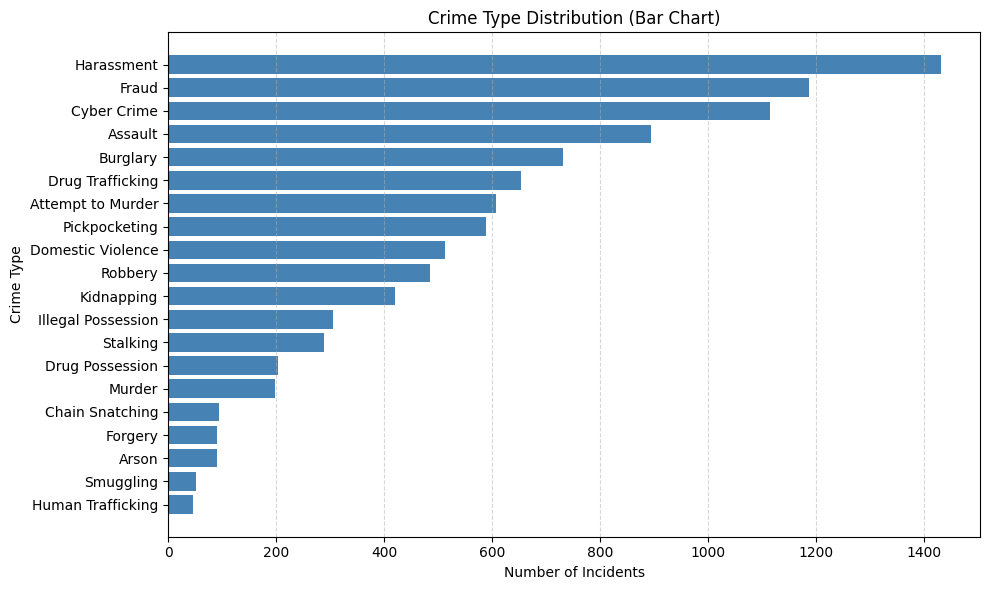

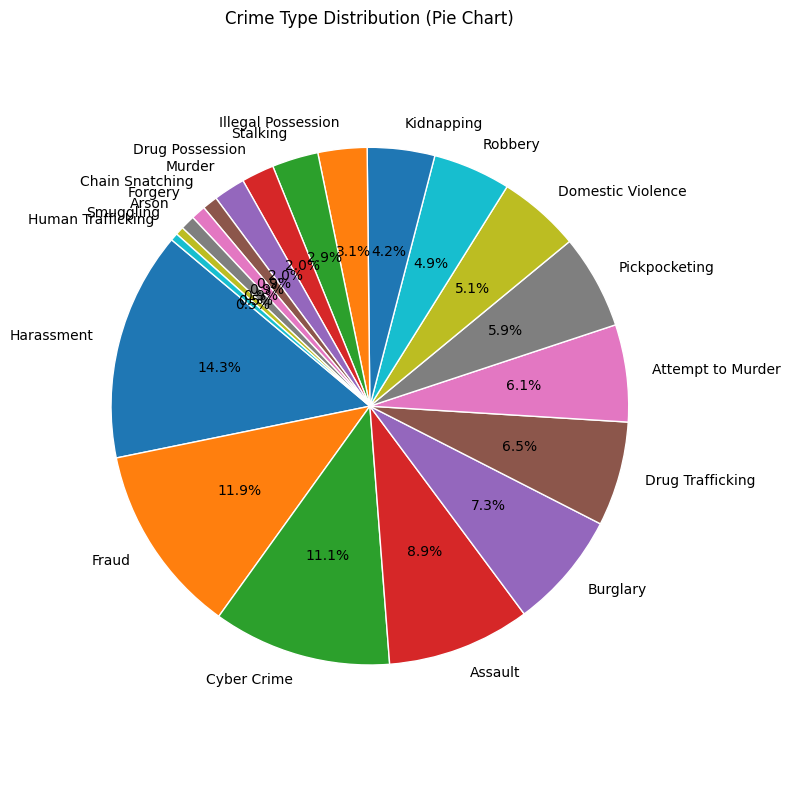

In [ ]:
import matplotlib.pyplot as plt


# 1. Aggregate counts by crime_type
crime_counts_pdf = (
    df.groupBy("crime_type")
      .count()
      .orderBy("count", ascending=False)
      .toPandas()
)

# 2. bar Chart
plt.figure(figsize=(10,6))
plt.barh(crime_counts_pdf['crime_type'][::-1],   # reverse for descending on a horizontal bar
         crime_counts_pdf['count'][::-1],
         color='steelblue')
plt.xlabel('Number of Incidents')
plt.ylabel('Crime Type')
plt.title('Crime Type Distribution (Bar Chart)')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#pie Chart
plt.figure(figsize=(8,8))
plt.pie(crime_counts_pdf['count'], 
        labels=crime_counts_pdf['crime_type'], 
        autopct='%1.1f%%', 
        startangle=140,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
plt.title('Crime Type Distribution (Pie Chart)')
plt.axis('equal')
plt.tight_layout()
plt.show()



+---------------+-----+
|           area|count|
+---------------+-----+
|          Majra| 2031|
|       Mohanpur| 1637|
|     Gulab Bagh| 1116|
|   Subhash Road|  979|
|Saharanpur Road|  834|
|      Mohkampur|  621|
|     Prem Nagar|  532|
|          Malsi|  487|
|Industrial Area|  442|
|         Kudkan|  396|
|    Rajpur Road|  368|
| Shivaji Colony|  297|
|     CID Colony|  225|
| Mussoorie Road|   35|
+---------------+-----+



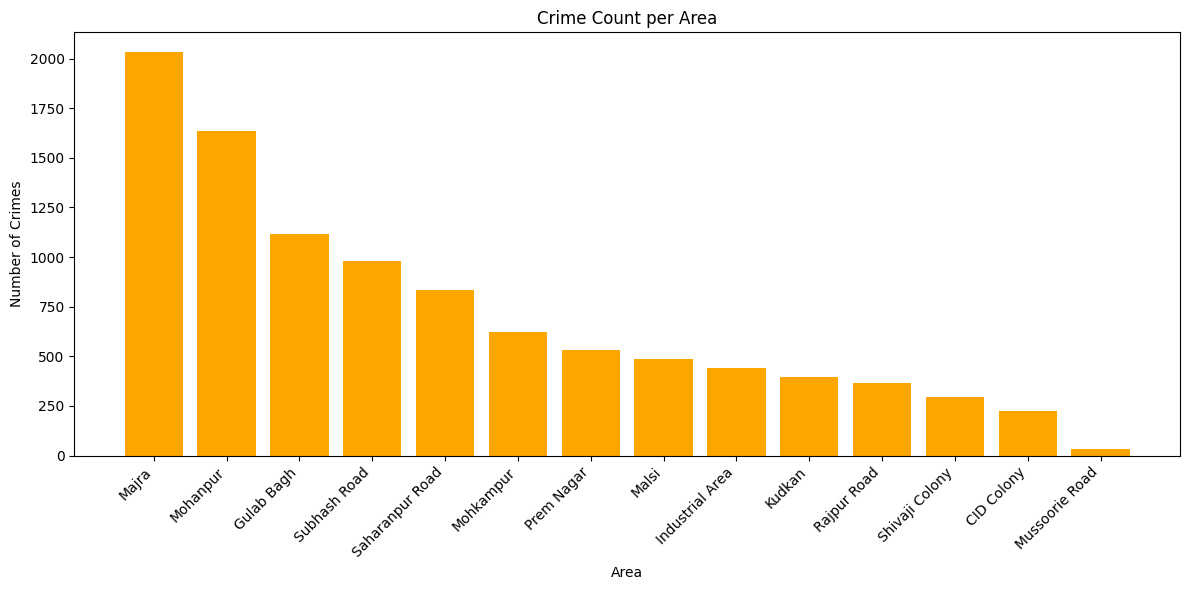

In [66]:
# Group by 'area' and count the crimes
area_crime_counts = df.groupBy("area").count().orderBy("count", ascending=False)

# Show top 10 areas with highest crime counts
area_crime_counts.show()
# Convert to Pandas (only use .toPandas() on small data)
area_counts_pd = area_crime_counts.toPandas()

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(area_counts_pd['area'], area_counts_pd['count'], color='orange')
plt.xticks(rotation=45, ha='right')
plt.title('Crime Count per Area')
plt.xlabel('Area')
plt.ylabel('Number of Crimes')
plt.tight_layout()
plt.show()

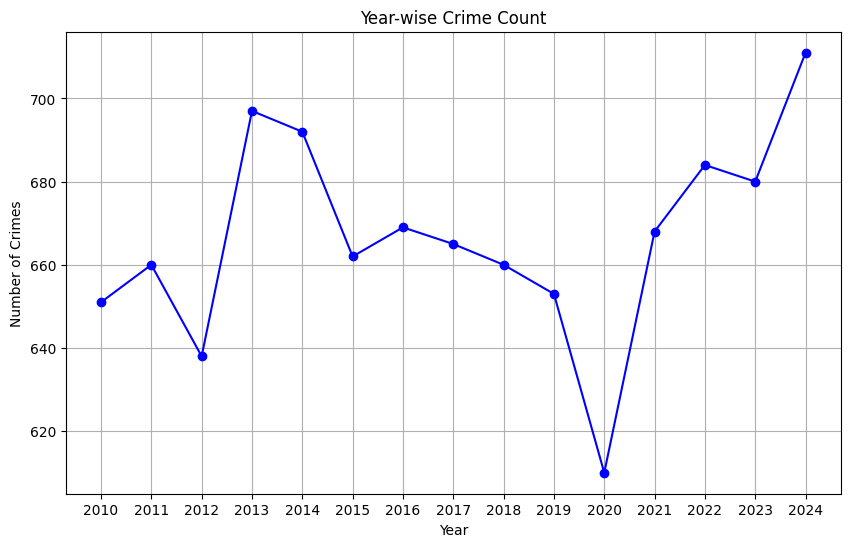

In [67]:
from pyspark.sql.functions import col

# Group by year and count crimes
yearly_crime_counts = df.groupBy("year").count().orderBy("year")

# Convert to Pandas for plotting
pdf = yearly_crime_counts.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(pdf['year'], pdf['count'], marker='o', linestyle='-', color='b')
plt.title('Year-wise Crime Count')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.xticks(pdf['year'])  # Show all years on x-axis for clarity
plt.show()


In [72]:
import folium
from folium.plugins import HeatMap
import pandas as pd

# If you already have df as a PySpark DataFrame, convert it:
pandas_df = df.select("latitude", "longitude").dropna().toPandas()

# Or load directly if you have a CSV locally:
# pandas_df = pd.read_csv("data/dehradun_crime_data.csv")[["latitude", "longitude"]].dropna()

# Prepare data for the heatmap: list of [lat, lon] pairs
heat_data = pandas_df.values.tolist()

# Initialize a Folium map centered on Dehradun (approximate center)
m = folium.Map(location=[30.3165, 78.0322], zoom_start=12)

# Add the heatmap layer
HeatMap(data=heat_data, radius=10, blur=15, min_opacity=0.2).add_to(m)

# Save map to HTML for viewing
m.save("crime_density_heatmap.html")

# If in a notebook, you can display it inline:
# from IPython.display import IFrame
# IFrame("crime_density_heatmap.html", width=700, height=500)


In [79]:
# model to predict response time 

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# STEP 1: Select relevant columns & drop missing values
features = ['area', 'crime_category', 'no_of_cctv', 'weather_condition', 'day_of_week']
model_df = df.select(*features, 'response_time_min').dropna()

# STEP 2: Encode categorical variables
indexers = [
    StringIndexer(inputCol=column, outputCol=column + "_index", handleInvalid='keep')
    for column in ['area', 'crime_category', 'weather_condition', 'day_of_week']
]

# STEP 3: Assemble features into a single vector
assembler = VectorAssembler(
    inputCols=[col + "_index" for col in ['area', 'crime_category', 'weather_condition', 'day_of_week']] + ['no_of_cctv'],
    outputCol="features"
)

# STEP 4: Define Random Forest model
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="response_time_min",
    numTrees=50,
    maxDepth=10,
    seed=42
)

# STEP 5: Create and fit pipeline
pipeline = Pipeline(stages=indexers + [assembler, rf])
model = pipeline.fit(model_df)

# STEP 6: Make predictions
predictions = model.transform(model_df)

# STEP 7: Evaluate the model
evaluator = RegressionEvaluator(
    labelCol="response_time_min",
    predictionCol="prediction",
    metricName="rmse"
)
# rmse = evaluator.evaluate(predictions)
# print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Optional: Show predictions
# predictions.select('area', 'crime_category', 'no_of_cctv', 'response_time_min', 'prediction').show(10)


25/05/21 22:33:26 WARN DAGScheduler: Broadcasting large task binary with size 1191.8 KiB
25/05/21 22:33:27 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/21 22:33:28 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/21 22:33:31 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
25/05/21 22:33:32 WARN DAGScheduler: Broadcasting large task binary with size 1519.2 KiB


In [80]:
# Save model
model.write().overwrite().save("response_time_model")


In [81]:
from pyspark.ml import PipelineModel

# Load model
loaded_model = PipelineModel.load("response_time_model")

sample_data = spark.createDataFrame([
    ("Majra", "Violent Crime", 4, "Clear", "Friday"),
    ("Malsi", "Property Crime", 2, "Rainy", "Monday"),
    ("Prem Nagar", "White Collar Crime", 6, "Foggy", "Sunday")
], ["area", "crime_category", "no_of_cctv", "weather_condition", "day_of_week"])

# Make predictions
sample_predictions = loaded_model.transform(sample_data)

# Show predictions
sample_predictions.select("area", "crime_category", "no_of_cctv", "prediction").show()

+----------+------------------+----------+------------------+
|      area|    crime_category|no_of_cctv|        prediction|
+----------+------------------+----------+------------------+
|     Majra|     Violent Crime|         4| 31.11432835252235|
|     Malsi|    Property Crime|         2|33.808028240742985|
|Prem Nagar|White Collar Crime|         6| 38.02681171661675|
+----------+------------------+----------+------------------+



25/05/21 22:54:18 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 10 (= number of training instances)


Root Mean Squared Error (RMSE): 38.75


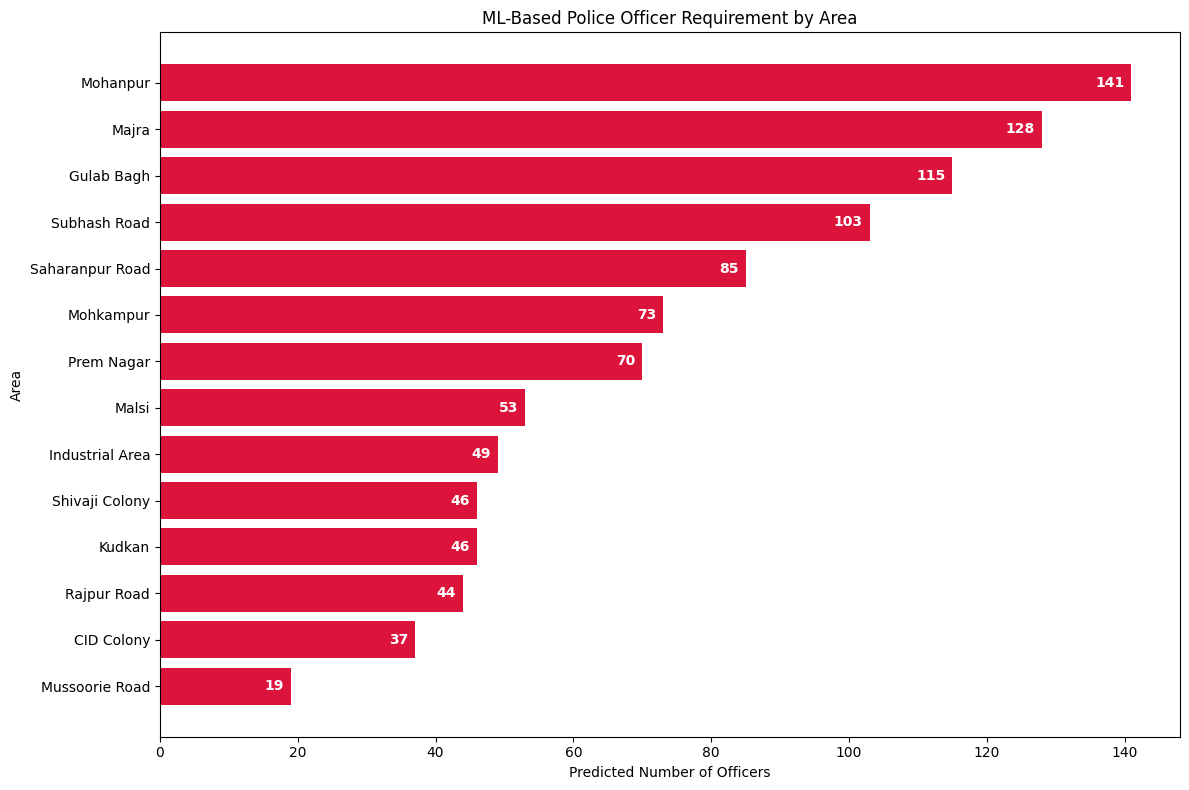

In [85]:
from pyspark.sql.functions import col, avg, count, sum as sum_, when

# Step 1: Aggregate features by area
area_features = df.groupBy("area").agg(
    count("*").alias("crime_count"),
    avg("response_time_min").alias("avg_response_time"),
    avg("no_of_cctv").alias("avg_cctv"),
    (sum_(when(col("is_festival_day") == 1, 1).otherwise(0)) / count("*")).alias("festival_day_ratio")
)

# Step 2: Add a proxy label for officers based on crime density
scaling_factor = 10  # You can adjust this to control officer numbers
area_features = area_features.withColumn(
    "recommended_officers",
    (col("crime_count") / scaling_factor).cast("int")
)

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Step 1: Prepare features
assembler = VectorAssembler(
    inputCols=["crime_count", "avg_response_time", "avg_cctv", "festival_day_ratio"],
    outputCol="features"
)
data = assembler.transform(area_features).select("features", "recommended_officers")

# Step 2: Train/test split
train, test = data.randomSplit([0.8, 0.2], seed=42)

# Step 3: Train model
rf = RandomForestRegressor(featuresCol="features", labelCol="recommended_officers", numTrees=50)
model = rf.fit(train)

# Step 4: Predict and evaluate
# Step 1: Keep area info with features
area_with_features = assembler.transform(area_features)

# Step 2: Predict using trained model
predictions = model.transform(area_with_features)

# Step 3: Select area and predicted officers
result = predictions.select("area", "prediction")

# Step 4: Convert to Pandas for plotting
area_pdf = result.toPandas()

# Optional: Round prediction
area_pdf["prediction"] = area_pdf["prediction"].round(0)

# Step 5: Sort for clean plotting
area_pdf = area_pdf.sort_values(by="prediction", ascending=False)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")



import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
bars = plt.barh(area_pdf["area"], area_pdf["prediction"], color="crimson")

plt.xlabel("Predicted Number of Officers")
plt.ylabel("Area")
plt.title("ML-Based Police Officer Requirement by Area")
plt.gca().invert_yaxis()

# Add text labels inside the bars
for bar in bars:
    width = bar.get_width()
    plt.text(
        width - 1,                      # X position (slightly left inside)
        bar.get_y() + bar.get_height()/2,  # Y position centered vertically
        f"{int(width)}",                # Text (convert to int for cleaner look)
        va='center', ha='right',        # Centered vertically, right-aligned
        color='white', fontsize=10, fontweight='bold'
    )

plt.tight_layout()
plt.show()




25/05/21 23:18:38 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 14 (= number of training instances)


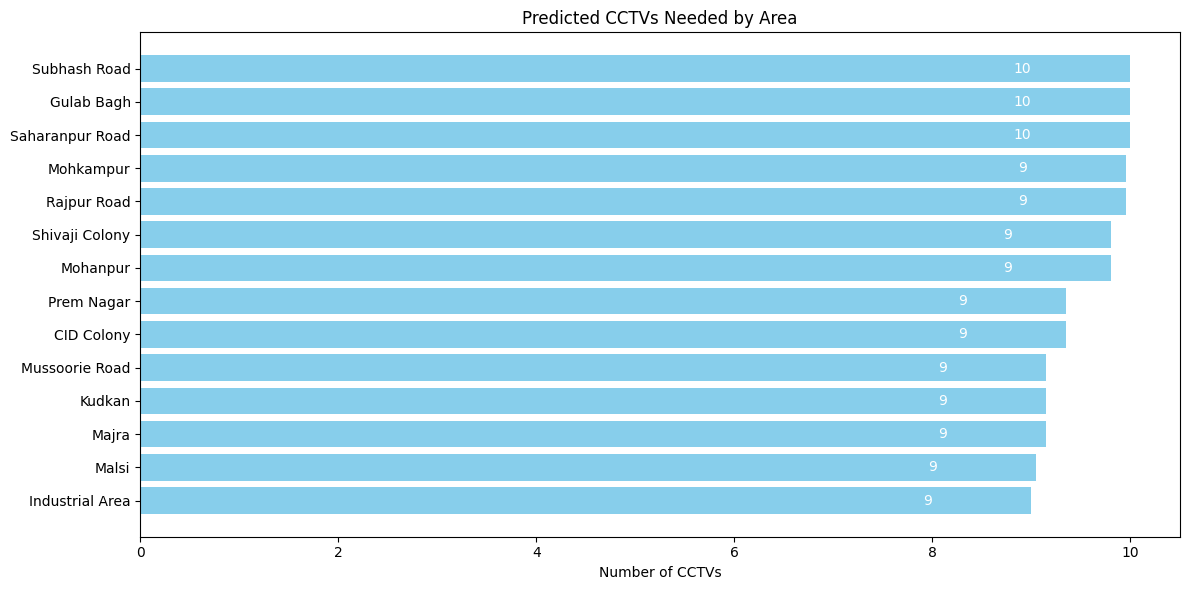

25/05/22 07:16:16 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 193528 ms exceeds timeout 120000 ms
25/05/22 07:16:16 WARN SparkContext: Killing executors is not supported by current scheduler.
25/05/22 07:16:23 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [86]:
# 1.1 — Import libraries
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

# 1.2 — Prepare area‐level features (aggregate by area)
area_df = df.groupBy("area").agg(
    count("*").alias("crime_count"),
    avg("response_time_min").alias("avg_response_time"),
    avg("no_of_cctv").alias("current_cctv")
)

# 1.3 — Define a proxy label: how many CCTVs you’d need 
#       to halve the avg_response_time (just an example heuristic)
area_df = area_df.withColumn(
    "needed_cctv",
    ((col("current_cctv") * (col("avg_response_time") / (col("avg_response_time")/2))).cast("int"))
)

# 1.4 — Assemble features and train
assembler = VectorAssembler(
    inputCols=["crime_count", "avg_response_time", "current_cctv"],
    outputCol="features"
)
train_df = assembler.transform(area_df).select("features", "needed_cctv")

rf = RandomForestRegressor(labelCol="needed_cctv", featuresCol="features", numTrees=20)
model_cctv = rf.fit(train_df)

# 1.5 — Make predictions
predictions_cctv = model_cctv.transform(train_df).select("features", "needed_cctv", "prediction")

# 1.6 — Join back to area names for plotting
area_features = assembler.transform(area_df)
results = model_cctv.transform(area_features)\
    .select("area", "needed_cctv", col("prediction").alias("predicted_cctv"))\
    .toPandas()

# 1.7 — Plot with numbers inside bars
import matplotlib.pyplot as plt

results = results.sort_values("predicted_cctv", ascending=False)
plt.figure(figsize=(12,6))
bars = plt.barh(results["area"], results["predicted_cctv"], color="skyblue")
for bar in bars:
    w = bar.get_width()
    plt.text(w-1, bar.get_y()+bar.get_height()/2, f"{int(w)}", va="center", ha="right", color="white")
plt.gca().invert_yaxis()
plt.title("Predicted CCTVs Needed by Area")
plt.xlabel("Number of CCTVs")
plt.tight_layout()
plt.show()
